First figure of the manuscript, showing "broadband" timescales. 
- Brain maps of timescales across wake and sleep stages.
- Overall timescales changes in wake and sleep across all brain areas.
- Correlation sizes of timescales with T1w/T2w score.

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from pathlib import Path
from copy import deepcopy
import pandas as pd
import numpy as np
import pickle
from scipy.stats import zscore, bootstrap, ttest_rel
import matplotlib.pyplot as plt
import mne
import nibabel as nib

from mnitimescales import utils
from mnitimescales import plots

plots._set_font_params()

Imports and definitions:

In [5]:
stages = ["W", "N2", "N3", "R"]
stage_colors = {"W": "red", "N2": "cyan", "N3": "purple", "R": "green"}
title_dict = {"W": "Wake", "N2": "NREM2", "N3": "NREM3", "R": "REM"}
corr_type = "pearson"

# Paths
data_path = Path("F:\\MNIOpen")
tau_path = data_path.joinpath("Results", "timescales_theta")
fig_path = data_path.joinpath("Figures", "Fig_theta")
fig_path.mkdir(exist_ok=True, parents=True)
df_timescales_stages = {
    stage: pd.read_csv(tau_path.joinpath(f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}

# Parcellation
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "HCPMMP1"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
labels_mne = mne.read_labels_from_annot(
    "fsaverage", parc_map_name, "lh", subjects_dir=subjects_dir
)
parc_labels, ctab, parc_names = nib.freesurfer.read_annot(annot_file)

Reading labels from parcellation...
   read 181 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\lh.HCPMMP1.annot


### A) Average ACFs across wake and sleep 

Comparison of average ACF curves across wake and sleep stages.

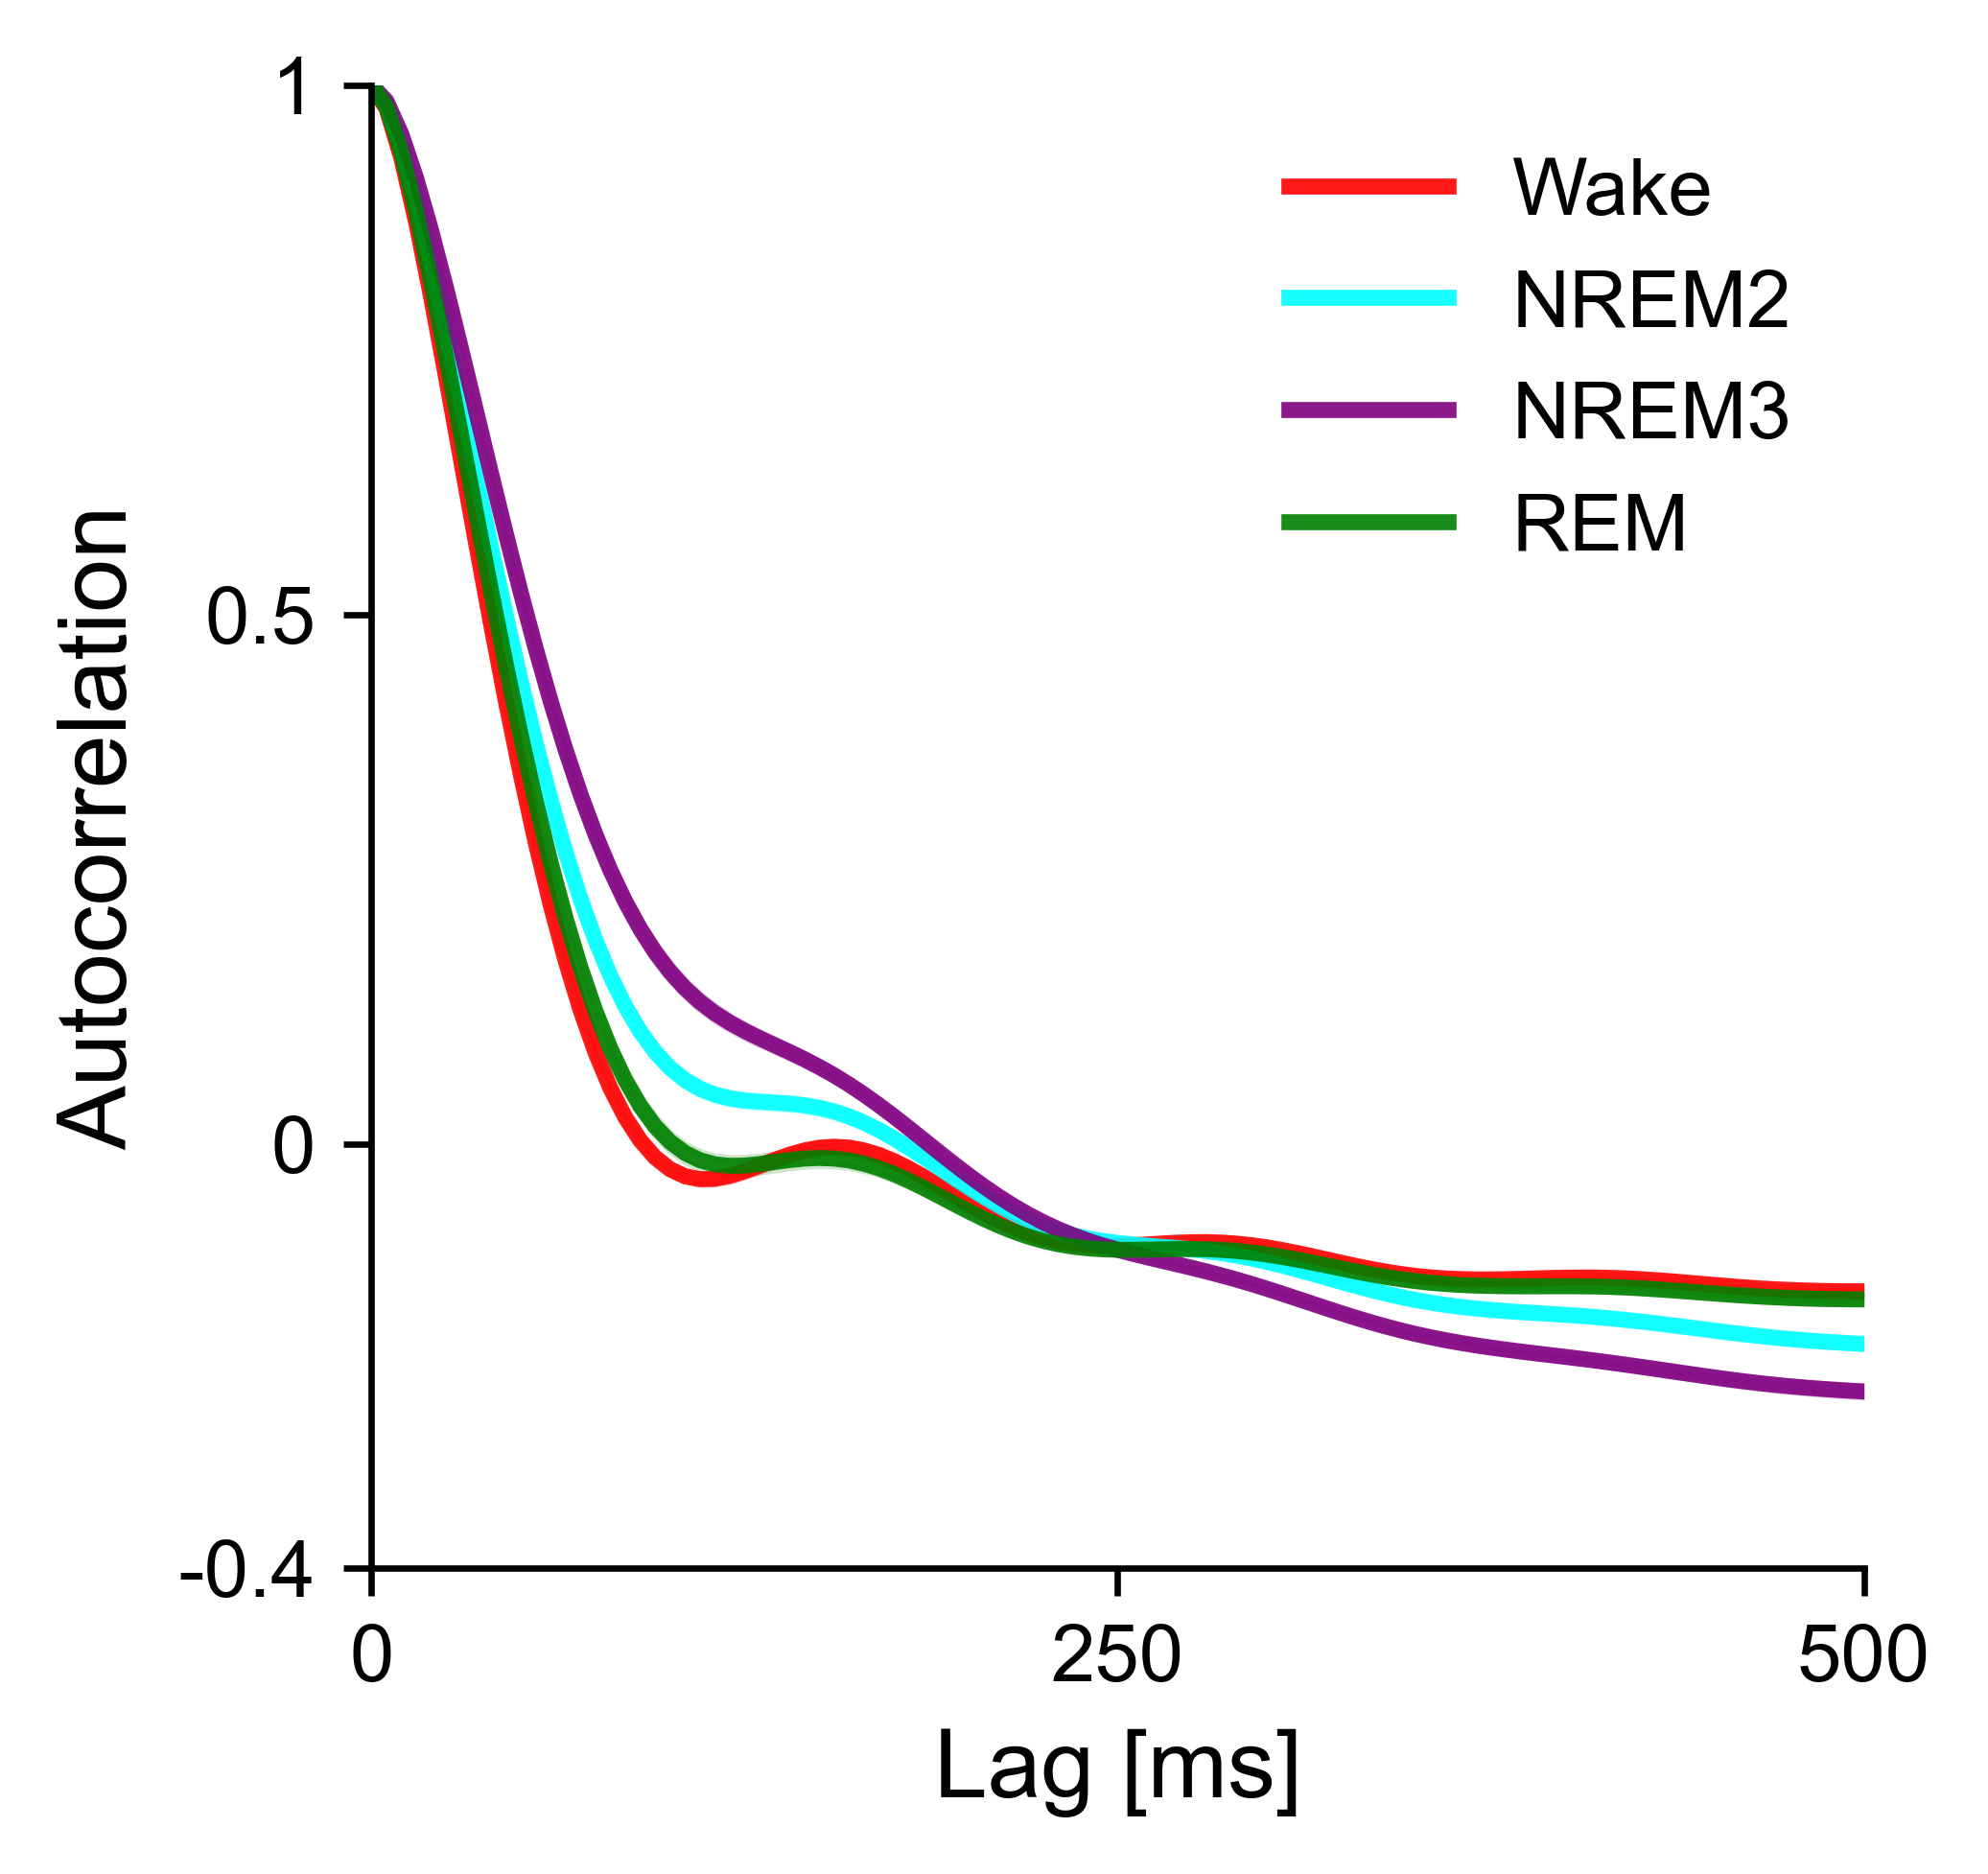

In [6]:
# Set up the figure
fig, ax = plt.subplots(figsize=plots._get_figsize_inches((8.5, 8.5)), dpi=600)

# Find patients subfolders
pats = [pat.stem for pat in tau_path.joinpath("Pats").glob("*") if pat.is_dir()]

# Loop through stages
for stage in stages:

    # Store ACF for all patients
    acf_pats_stage = []
    lags = None

    # Loop through patients
    for pat in pats:
        pat_dir = tau_path.joinpath("Pats").joinpath(pat)
        # Load ACF
        try:
            with open(
                pat_dir.joinpath("ACF/" + pat + "_" + stage.lower() + ".pkl"),
                "rb",
            ) as f:
                acf_pat_stage = pickle.load(f)
        except FileNotFoundError:
            continue

        # Append channels
        acf_pats_stage.append(acf_pat_stage["acf"].mean(axis=0).mean(axis=0))
        if lags is None:
            lags = acf_pat_stage["lags"]

    # Average across patients
    N_pats = len(acf_pats_stage)
    acf_pats_stage = np.stack(acf_pats_stage)
    acf_stage_avg = acf_pats_stage.mean(axis=0)
    acf_stage_se = acf_pats_stage.std(axis=0) / np.sqrt(N_pats)

    # Figure ACF
    ax.plot(
        lags * 1000,
        acf_stage_avg,
        c=stage_colors[stage],
        label=title_dict[stage],
        lw=2,
        alpha=0.9,
    )
    ax.fill_between(
        lags * 1000,
        acf_stage_avg - acf_stage_se,
        acf_stage_avg + acf_stage_se,
        color=stage_colors[stage],
        alpha=0.2,
    )
# Plot parameters
# ax.set_title("Average Broadband ACF", fontsize=fsize.TITLE_SIZE)
ax.set_xlim(0, 500)
ax.set_xticks([0, 250, 500], labels=[0, 250, 500], fontsize=plots.fsize.TICK_SIZE)
ax.set_xlabel("Lag [ms]", fontsize=plots.fsize.LABEL_SIZE)
ax.set_ylim(-0.4, 1)
ax.set_yticks(
    [-0.4, 0, 0.5, 1], labels=[-0.4, 0, 0.5, 1], fontsize=plots.fsize.TICK_SIZE
)
ax.set_ylabel("Autocorrelation", fontsize=plots.fsize.LABEL_SIZE)
ax.spines[["top", "right"]].set_visible(False)
ax.legend(frameon=False, fontsize=plots.fsize.TICK_SIZE, loc="upper right")

# Save figure
plots.save_figure(fig, fig_path.joinpath(f"ACF_average.svg"))

plt.show()

### B) Average increase of tau during sleep

Slope plot with averaged difference of timescales between wake and sleep stages across all areas of the parcellation.

diff W - N2 : 19.021863064255726 1.0759468718994494e-93
diff W - N3 : 42.8208404728571 4.3861322912097086e-117
diff W - R : 5.985675607358674 2.0921831366383374e-21


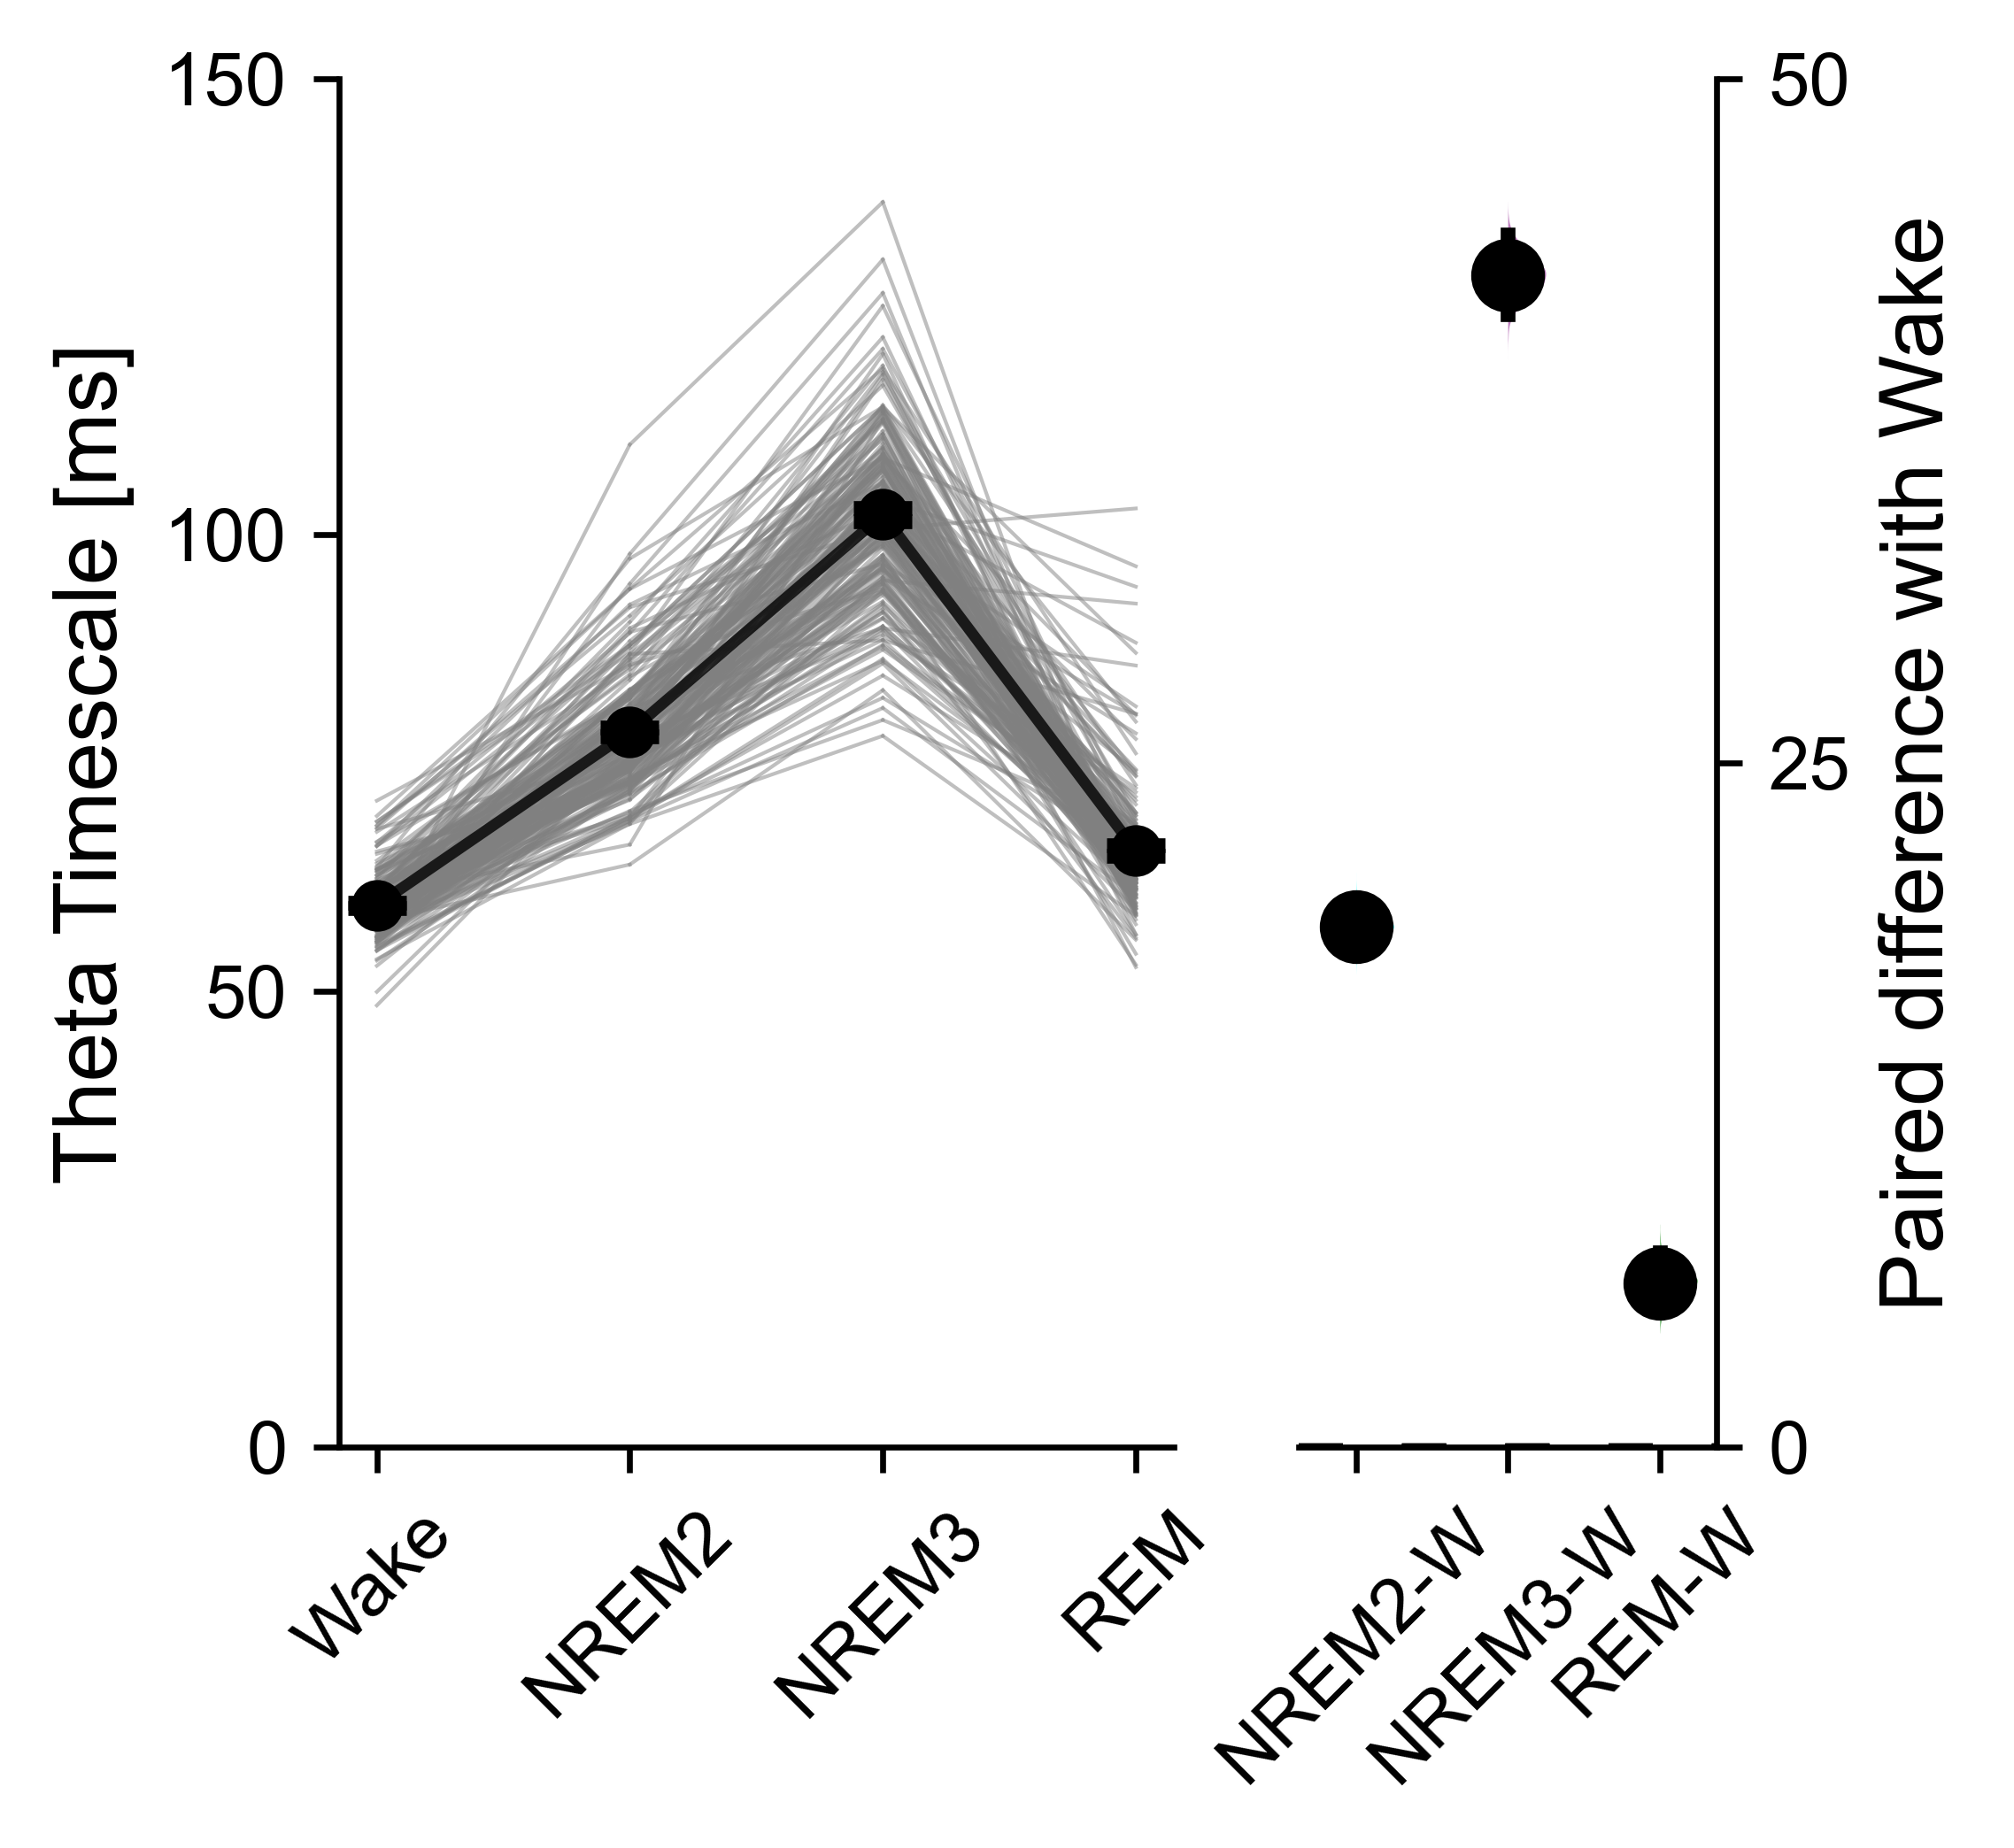

In [10]:
# Prepare dataframe for plotting
df_plot = deepcopy(df_timescales_stages)
for stage in stages:
    df_plot[stage]["stage"] = stage
df_plot = pd.concat(df_plot.values())
df_plot.rename(columns={"0": "tau"}, inplace=True)
df_plot = df_plot.pivot(columns="stage", values="tau")
df_plot = df_plot[stages]

# Figure
fig, axs = plt.subplots(
    1,
    2,
    figsize=plots._get_figsize_inches((8.5, 8.5)),
    width_ratios=[2, 1],
    dpi=600,
)

# Slope plot
axs[0] = plots.slope_plot(axs[0], df_plot)
# Plot parameters
axs[0].set_ylabel("Theta Timescale [ms]", fontsize=plots.fsize.LABEL_SIZE)
axs[0].set_ylim(0, 150)
axs[0].set_yticks(
    [0, 50, 100, 150],
    labels=[0, 50, 100, 150],
    fontsize=plots.fsize.TICK_SIZE,
)
axs[0].set_xticks(
    range(len(stages)),
    [title_dict[stage] for stage in stages],
    rotation=45,
    ha="center",
    fontsize=plots.fsize.TICK_SIZE,
)


# Add contrasts
def avg_diff(x, y):
    return np.mean(x - y)


# Plot differences
for i, stage in enumerate(stages[1:]):
    avg = avg_diff(df_plot[stage], df_plot["W"])
    pval = ttest_rel(df_plot[stage], df_plot["W"])[1]
    p_str = f"p = {pval:.2f}" if pval >= 0.001 else "p < 0.001"
    p_str += "*" if pval < 0.05 else ""
    print("diff W -", stage, ":", avg, pval)
    res_boot = bootstrap(
        (df_plot[stage], df_plot["W"]),
        avg_diff,
        paired=True,
        random_state=290496,
    )
    axs[1] = plots.half_violin_plot(
        axs[1],
        avg,
        x_pos=i,
        ci=list(res_boot.confidence_interval),
        y_boot=res_boot.bootstrap_distribution,
        color=stage_colors[stage],
        pval=None,
    )
# Plot parameters
axs[1].set_ylabel("Paired difference with Wake", fontsize=plots.fsize.LABEL_SIZE)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_ylim(0, 50)
axs[1].set_yticks(
    [0, 25, 50],
    labels=[0, 25, 50],
    fontsize=plots.fsize.TICK_SIZE,
)
axs[1].set_xticks(
    range(len(stages) - 1),
    [title_dict[stage] + "-W" for stage in stages[1:]],
    rotation=45,
    fontsize=plots.fsize.TICK_SIZE,
)
axs[1].spines[["top", "left"]].set_visible(False)

# Save figure
plots.save_figure(fig, fig_path.joinpath(f"tau_change_stages.svg"))
plt.show()

### C) Plot of parcellated brain areas

Plot absolute values and differences between stages of timescales in the HCP_MMP parcellation.

In [15]:
minmax_stages = {"W": (55, 70), "N2": (70, 95), "N3": (80, 120), "R": (55, 85)}

# Loop through stages
for stage in stages:

    fig, ax = plots.plot_parcellated_metric(
        df_timescales_stages[stage].to_numpy().squeeze(),
        parc_labels,
        subjects_dir,
        labels_mne,
        log_scale=False,
        minmax=minmax_stages[stage],
        title=title_dict[stage],
        cmap="viridis",
        label="Timescale [ms]",
        cbar_format="0f",
    )

    fig.savefig(
        fig_path.joinpath(f"tau_parc_{stage}.svg"),
        format="svg",
        transparent=True,
    )
    plt.close(fig)

Using pyvistaqt 3d backend.



c:\Users\ricca\anaconda3\envs\mni_analysis\lib\site-packages\pyvista\plotting\plotting\__init__.py:23: PyVistaDeprecationWarning: The `pyvista.plotting.plotting` module has been deprecated. `_ALL_PLOTTERS` is now imported as: `from pyvista.plotting import _ALL_PLOTTERS`.
  warnings.warn(


Maps of differences

In [18]:
(df_timescales_stages["R"] - df_timescales_stages["W"]).quantile([0.025, 0.975])

,0
0.025,-4.305423
0.975,28.985903


In [19]:
# Differences
df_plot_W_N2 = df_timescales_stages["N2"] - df_timescales_stages["W"] 
df_plot_W_N3 = df_timescales_stages["N3"] - df_timescales_stages["W"]  # [20, 85]
df_plot_W_R = df_timescales_stages["R"] - df_timescales_stages["W"]  # [-5, 30]

# NREM2 figure
fig, ax = plots.plot_parcellated_metric(
    df_plot_W_N2.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    labels_mne,
    log_scale=False,
    minmax=(5, 30),
    zero_center=False,
    title="NREM2 - Wake",
    cmap="Reds",
    label="Timescale difference [ms]",
    cbar_format="0f",
)
fig.savefig(fig_path.joinpath(f"tau_parc_N2-W.svg"), format="svg", transparent=True)
plt.close(fig)

# NREM3 figure
fig, ax = plots.plot_parcellated_metric(
    df_plot_W_N3.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    labels_mne,
    log_scale=False,
    minmax=(25, 65),
    zero_center=False,
    title="NREM3 - Wake",
    cmap="Reds",
    label="Timescale difference [ms]",
    cbar_format="0f",
)
fig.savefig(fig_path.joinpath(f"tau_parc_N3-W.svg"), format="svg", transparent=True)
plt.close(fig)


# REM figure
fig, ax = plots.plot_parcellated_metric(
    df_plot_W_R.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    labels_mne,
    log_scale=False,
    minmax=(-5, 30),
    zero_center=True,
    title="REM - Wake",
    cmap="bwr",
    label="Timescale difference [ms]",
    cbar_format="0f",
)
fig.savefig(fig_path.joinpath(f"tau_parc_R-W.svg"), format="svg", transparent=True)
plt.close(fig)

### D) Correlation with structure

Load T1w/T2w data and the centroids coordinates of the parcellation (for spin permutation):

In [25]:
df_struct = pd.read_csv(data_path.joinpath("Data", "Raw", "df_structural_avg.csv"), index_col=0)
map_coords = pd.read_csv(data_path.joinpath("Data", "Parcellation", "mmp_centroids_coords.csv"), index_col=0)

Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...


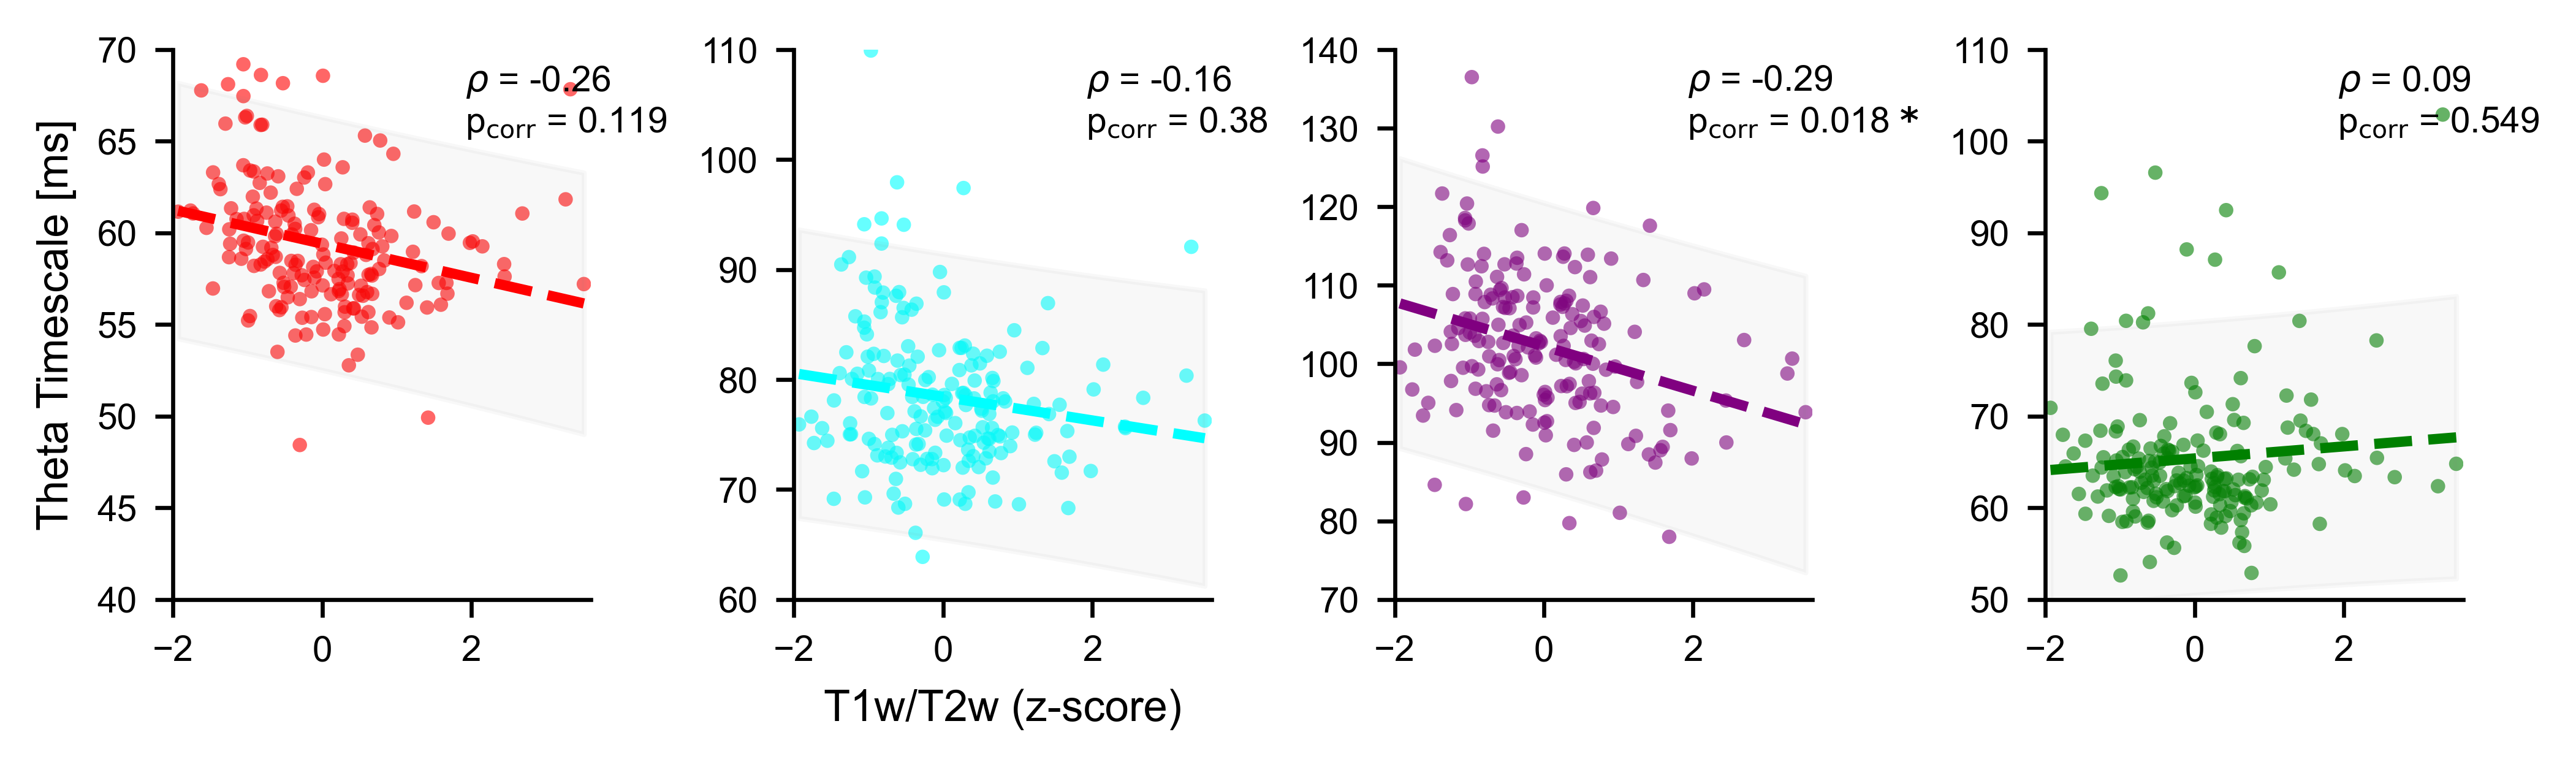

In [26]:
xlims = (-2, 3.6)
ylims_stages = {"W": (40, 70), "N2": (60, 110), "N3": (70, 140), "R": (50, 110)}

fig, axs = plt.subplots(
    1, len(stages), figsize=plots._get_figsize_inches((17.5, 5)), dpi=600, layout="constrained"
)

rhos, p_corrs, rhos_boot = {}, {}, {}

for i, stage in enumerate(stages):
    # Import dataframe
    df_metric = df_plot[stage].copy()

    # Get data
    x = zscore(df_struct["T1T2"], ddof=1).to_numpy()
    y = df_metric.loc[df_struct.index].to_numpy().squeeze()

    # Get correlation values
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
    rho_boot = utils.get_rho_boot(x, y, corr_type=corr_type)
    rhos[stage] = rho
    p_corrs[stage] = p_corr
    rhos_boot[stage] = rho_boot

    # Plot
    axs[i] = plots.plot_corr(
        axs[i],
        x,
        y,
        rho,
        p_corr,
        markersize=8,
        color=stage_colors[stage],
        xlabel="T1w/T2w (z-score)",  # "Anatomical Hierarchy Score",
        ylabel="Theta Timescale [ms]",
        xlims=xlims,
        ylims=ylims_stages[stage],
    )
    if i > 0:
        axs[i].set_ylabel("", fontsize=0)
    if i != 1:
        axs[i].set_xlabel("", fontsize=0)

# Save figure
plots.save_figure(fig, fig_path.joinpath(f"tau_corr_struct.svg"))

plt.show()

### S1) Correlation with broadband  and gamma timescales

W
Generating 1000 permutations...


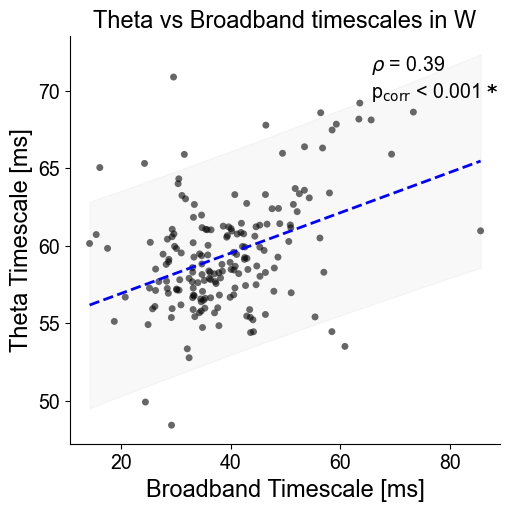

N2
Generating 1000 permutations...


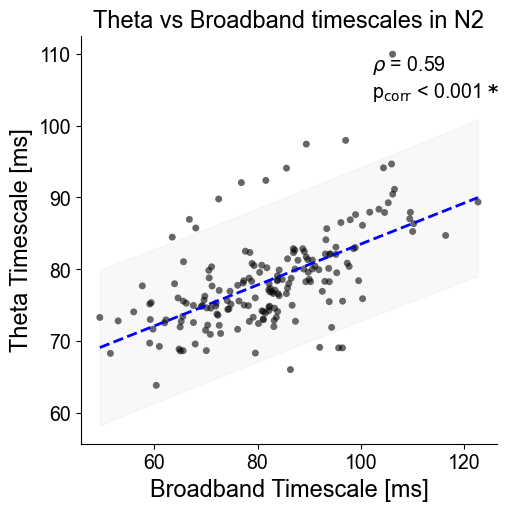

N3
Generating 1000 permutations...


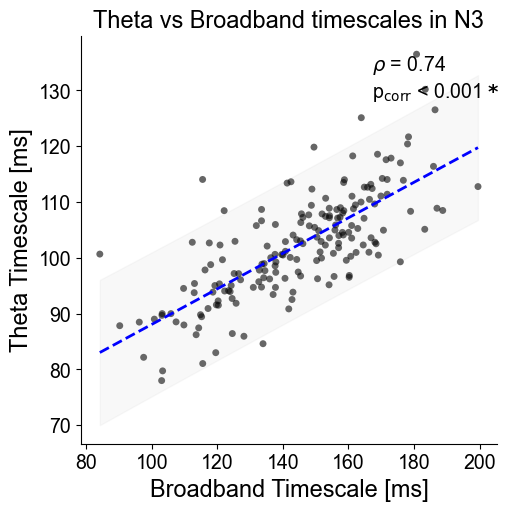

R
Generating 1000 permutations...


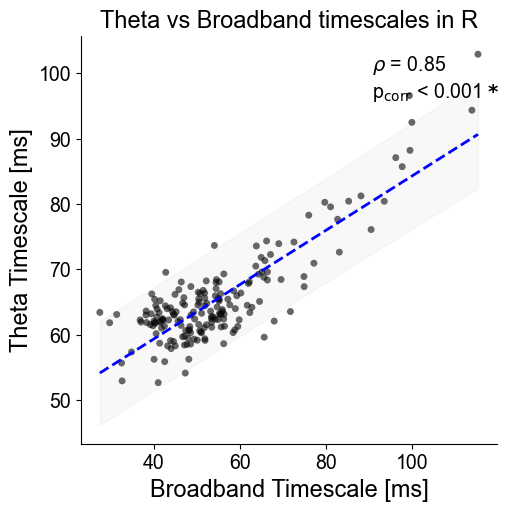

In [27]:
df_timescales_broadband = {
    stage: pd.read_csv(data_path.joinpath("Results", "timescales_broadband", f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}

for stage in stages:
    print(stage)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), layout="constrained")
    x = df_timescales_broadband[stage].loc[df_timescales_stages[stage].index].to_numpy().squeeze()
    y = df_timescales_stages[stage].to_numpy().squeeze()
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
    ax = plots.plot_corr(
        ax,
        x,
        y,
        rho,
        p_corr,
        color_line="b",
        figsize=(5*2.4, 5*2.4),  # 2.4 is to get inches
        markersize=25,
        title=f"Theta vs Broadband timescales in {stage}",
        xlabel="Broadband Timescale [ms]",
        ylabel="Theta Timescale [ms]",
    )

    plt.show()

W
Generating 1000 permutations...


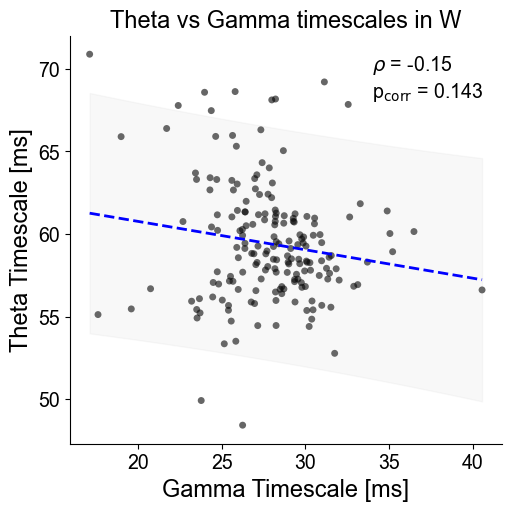

N2
Generating 1000 permutations...


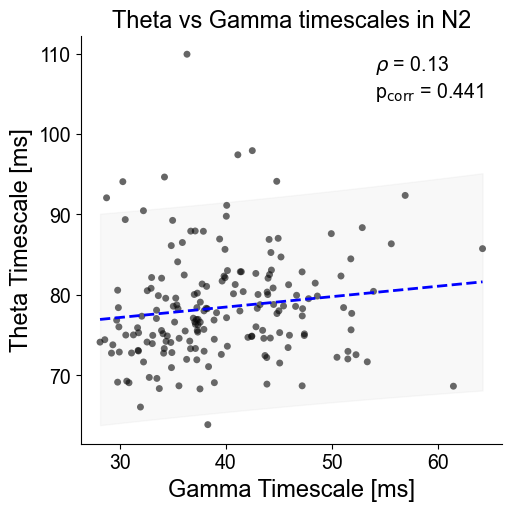

N3
Generating 1000 permutations...


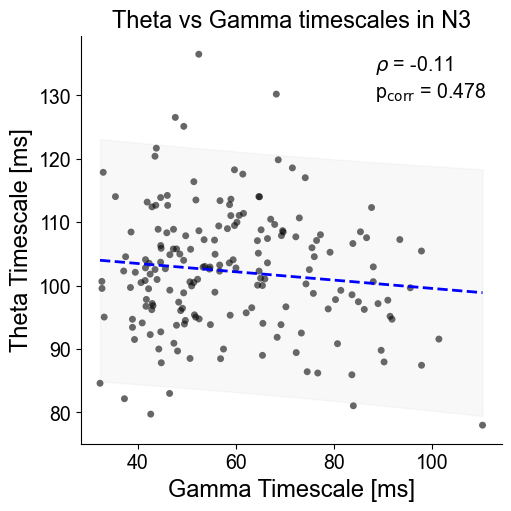

R
Generating 1000 permutations...


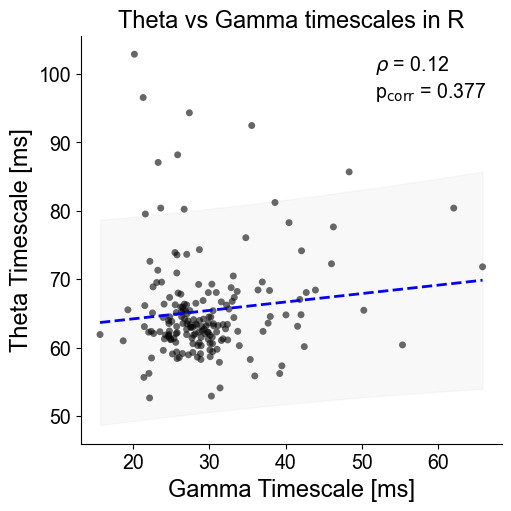

In [28]:
df_timescales_gamma = {
    stage: pd.read_csv(data_path.joinpath("Results", "timescales_gamma", f"tau_{stage}_mmp.csv"), index_col=0)
    for stage in stages
}

for stage in stages:
    print(stage)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5), layout="constrained")
    x = df_timescales_gamma[stage].loc[df_timescales_stages[stage].index].to_numpy().squeeze()
    y = df_timescales_stages[stage].to_numpy().squeeze()
    rho, p_corr = utils.get_pcorr(x, y, map_coords, method="vasa", corr_type=corr_type)
    ax = plots.plot_corr(
        ax,
        x,
        y,
        rho,
        p_corr,
        color_line="b",
        figsize=(5*2.4, 5*2.4),  # 2.4 is to get inches
        markersize=25,
        title=f"Theta vs Gamma timescales in {stage}",
        xlabel="Gamma Timescale [ms]",
        ylabel="Theta Timescale [ms]",
    )

    plt.show()